# Clustering and anomaly detection in light curves of periodic stars.

In [1]:
pip install lightkurve

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.4/270.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 27.7 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=1805b1094c8895a54aa8c22dc2e0daf0233f749753387352b27a9be4f8749b03
  Stored in directory: /root/.cache/pip/wheels/3c/ea/60/8d1c9fbbc99492a1775b36a5e29c8c1ef309cc5821bd5a219d
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-an

In [2]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset, TensorDataset, WeightedRandomSampler
import torch.nn.functional as F
import lightkurve as lk
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import umap.umap_ as umap
import time
import datetime
import seaborn as sns
from collections import Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score



# Load data

In [4]:
feats = pd.read_parquet('/content/drive/MyDrive/Inteligencia computacional/Proyecto/features.parquet')
lcs = pd.read_parquet('/content/drive/MyDrive/Inteligencia computacional/Proyecto/lcs.parquet')
oids = pd.read_parquet('/content/drive/MyDrive/Inteligencia computacional/Proyecto/oids.parquet')

# Data exploration

## Classes distribution

<Axes: xlabel='alerceclass'>

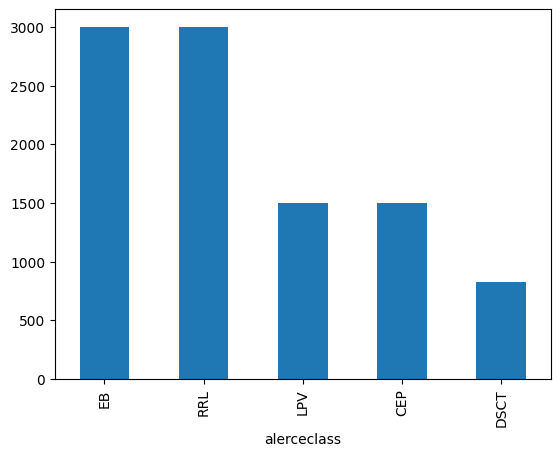

In [5]:
oids['alerceclass'].value_counts().plot.bar()

## Features

In [6]:
feats_by_oid = feats.reset_index()
feats_by_oid = feats.set_index('oid')
oids = oids.set_index('oid')

In [7]:
median_values = feats_by_oid.select_dtypes(include=[np.number]).median()
feats_filled = feats_by_oid.fillna(median_values)

df_concatenated = pd.concat([oids['alerceclass'], feats_filled], axis=1)
df_concatenated.dropna(inplace=True)

df_concatenated

,alerceclass,Q31_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,PairSlopeTrend_r,...,max_diffmaglim_after_fid_g,median_diffmaglim_after_fid_g,delta_mag_fid_r,delta_mjd_fid_r,first_mag_r,mean_mag_r,min_mag_r,n_det_r,PercentAmplitude_r,Harmonics_mag_5_r
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abmrdyx,CEP,0.327993,0.145209,-0.044641,-0.870908,0.195420,0.835062,1.0,0.000158,0.033333,...,20.605200,20.102501,0.685512,1346.190937,15.393001,15.361316,14.946087,127.0,0.031204,0.033489
ZTF18abdvyys,CEP,0.657821,0.184957,-0.453637,-1.119874,0.347335,0.912642,1.0,0.000661,0.033333,...,20.296200,19.485350,1.063133,1362.247535,13.470280,13.492689,12.974045,22.0,0.048942,0.114427
ZTF18abjgfrd,CEP,0.241344,0.204626,0.171970,-1.878280,0.119813,0.960020,1.0,0.000053,-0.033333,...,21.036800,20.151350,0.309963,1362.159144,16.484390,16.323530,16.177994,37.0,0.015189,0.236205
ZTF20aaksrbb,CEP,0.063570,0.436321,0.481466,-0.290408,0.042348,0.849919,1.0,0.000008,0.100000,...,21.025400,20.326300,0.117467,614.180752,14.485116,14.481151,14.436781,10.0,0.005410,260.767868
ZTF18abwqcoy,CEP,0.090321,0.237630,1.273315,0.891479,0.341080,0.738760,1.0,0.000303,0.066667,...,21.273800,20.220000,0.893099,797.913345,19.131857,19.246591,19.026735,13.0,0.044680,448.948945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF17aabdvwy,RRL,0.306074,0.166266,0.527270,-1.606645,0.150983,0.839271,1.0,0.000132,0.033333,...,20.912500,20.177500,0.386272,1321.736516,13.335348,13.139966,12.978258,58.0,0.024895,0.026694
ZTF19aaxpxxb,RRL,0.327993,0.145209,-0.044641,-0.870908,0.195420,0.835062,1.0,0.000158,0.033333,...,20.521800,19.842000,0.076391,730.057975,16.873110,16.895915,16.873110,5.0,0.031204,1.896084
ZTF18aaivxku,RRL,0.188431,0.094004,0.886813,-0.985129,0.092410,0.842141,1.0,0.000037,-0.100000,...,21.085400,20.073501,0.274776,1447.027477,15.143198,15.199926,15.104877,141.0,0.014904,0.005609


## Random Forest (to get top features)


In [9]:
# Separate features (X) and labels (y)
X = df_concatenated.drop(columns=['alerceclass'])
y = df_concatenated['alerceclass']

# Apply SMOTE to balance the data
smote = SMOTE(random_state=10)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstruct the resampled DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['alerceclass'])], axis=1)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_concatenated.drop(columns=['alerceclass']))


In [11]:
X = scaled_features
y = df_concatenated['alerceclass']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [12]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=5)

# RandomForestClassifier model
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [5, 50, 100],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}
# Stratified k-fold cross-validation

# Set up GridSearchCV
grid_search = RandomizedSearchCV(model, param_grid,
                           cv=skf, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2}
Best score: 0.9226202459279611


In [13]:
# Get feature importances from the model
importances = best_model.feature_importances_

# Sort and select the top 50 features
indices = np.argsort(importances)[::-1]
top_indices = indices[:50]


# Get the feature names of the top 50 features
feature_names = df_concatenated.drop(columns=['alerceclass']).columns
top_feature_names = feature_names[top_indices]

# Print the names of the top 10 features
print("Top 50 features:")
print(top_feature_names)

Top 50 features:
Index(['Multiband_period_g_r', 'Period_band_g', 'g-r_mean_g_r',
       'g-r_max_corr_g_r', 'g-r_max_g_r', 'r-W2', 'Period_band_r',
       'g-r_mean_corr_g_r', 'IAR_phi_r', 'g-W2', 'GP_DRW_tau_r', 'Gskew_g',
       'Autocor_length_r', 'IAR_phi_g', 'g-W3', 'Gskew_r', 'SF_ML_gamma_r',
       'Skew_g', 'Beyond1Std_g', 'r-W3', 'Harmonics_phase_2_g',
       'Autocor_length_g', 'MHPS_high_g', 'SF_ML_gamma_g',
       'n_non_det_after_fid_g', 'W1-W2', 'Power_rate_2_g_r', 'MedianAbsDev_g',
       'iqr_g', 'Harmonics_phase_2_r', 'W2-W3', 'Psi_CS_g', 'MHPS_high_r',
       'PPE_g_r', 'Harmonics_mse_r', 'n_non_det_after_fid_r', 'Q31_g',
       'delta_mag_fid_r', 'Amplitude_g', 'Std_g', 'n_det_r', 'GP_DRW_sigma_g',
       'gal_b', 'Harmonics_mse_g', 'positive_fraction_g', 'Psi_eta_r',
       'delta_mag_fid_g', 'Power_rate_3_g_r', 'Rcs_g', 'Skew_r'],
      dtype='object')


In [14]:
top_feature_names = ['Multiband_period_g_r', 'Period_band_g', 'g-r_mean_g_r',
       'g-r_max_corr_g_r', 'g-r_max_g_r', 'r-W2', 'Period_band_r',
       'g-r_mean_corr_g_r', 'IAR_phi_r', 'g-W2', 'GP_DRW_tau_r', 'Gskew_g',
       'Autocor_length_r', 'IAR_phi_g', 'g-W3', 'Gskew_r', 'SF_ML_gamma_r',
       'Skew_g', 'Beyond1Std_g', 'r-W3', 'Harmonics_phase_2_g',
       'Autocor_length_g', 'MHPS_high_g', 'SF_ML_gamma_g',
       'n_non_det_after_fid_g', 'W1-W2', 'Power_rate_2_g_r', 'MedianAbsDev_g',
       'iqr_g', 'Harmonics_phase_2_r', 'W2-W3', 'Psi_CS_g', 'MHPS_high_r',
       'PPE_g_r', 'Harmonics_mse_r', 'n_non_det_after_fid_r', 'Q31_g',
       'delta_mag_fid_r', 'Amplitude_g', 'Std_g', 'n_det_r', 'GP_DRW_sigma_g',
       'gal_b', 'Harmonics_mse_g', 'positive_fraction_g', 'Psi_eta_r',
       'delta_mag_fid_g', 'Power_rate_3_g_r', 'Rcs_g', 'Skew_r']
df_top_feats = df_concatenated[top_feature_names + ['alerceclass']]
# see features of LPV alerce clas
df_top_feats

,Multiband_period_g_r,Period_band_g,g-r_mean_g_r,g-r_max_corr_g_r,g-r_max_g_r,r-W2,Period_band_r,g-r_mean_corr_g_r,IAR_phi_r,g-W2,...,GP_DRW_sigma_g,gal_b,Harmonics_mse_g,positive_fraction_g,Psi_eta_r,delta_mag_fid_g,Power_rate_3_g_r,Rcs_g,Skew_r,alerceclass
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abmrdyx,1.209960,1.209960,0.475191,0.494172,0.406816,1.970592,0.409183,0.550950,0.081024,2.741381,...,0.104775,-17.487100,3.474082e-03,0.500000,0.216075,0.914144,0.003764,0.132344,-0.044641,CEP
ZTF18abdvyys,0.936007,0.936007,0.950694,0.739147,0.348549,3.313690,0.936007,0.957972,0.579824,4.271661,...,0.259100,9.216372,1.954657e-02,0.607843,0.717960,1.907177,0.020090,0.094605,-0.453637,CEP
ZTF18abjgfrd,5.406944,0.417950,0.475191,0.494172,0.406816,6.829530,5.406944,0.550950,0.181472,2.521917,...,0.054527,0.554165,2.380742e-03,0.449438,0.367651,0.814727,0.003672,0.123790,0.171970,CEP
ZTF20aaksrbb,0.651466,0.417950,1.895656,1.907801,1.540600,4.478151,0.651466,2.223222,0.461503,6.701373,...,0.065974,2.045647,2.608500e-28,0.333333,1.184539,0.594835,0.098109,0.123790,0.481466,CEP
ZTF18abwqcoy,1.042925,1.042925,0.263700,0.339783,-0.217066,1.970592,0.061588,1.066612,0.801748,2.521917,...,0.389553,-22.040270,4.890570e-03,0.400000,1.502035,1.796709,0.004593,0.158946,1.273315,CEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF17aabdvwy,0.228187,0.228187,0.060889,0.208128,0.070743,1.275965,0.228187,0.334593,0.536977,1.610558,...,0.041400,14.912810,3.533310e-04,0.457746,0.188195,0.537807,0.001526,0.108538,0.527270,RRL
ZTF19aaxpxxb,0.647889,0.647889,0.064978,0.070360,-0.562978,1.451915,0.409183,0.264136,0.081024,1.716050,...,0.010461,54.569847,2.299976e-03,0.150000,3.178585,0.498402,0.029564,0.206187,-0.044641,RRL
ZTF18aaivxku,0.267256,0.267256,-0.546041,-0.044440,-1.626974,0.597926,0.267256,0.147094,0.003321,0.745019,...,0.009757,38.881531,2.775572e-03,0.088608,0.086764,1.168021,0.000000,0.081313,0.886813,RRL


# Autoencoder con modelo de mezclas gaussianas


In [15]:
class AutoencoderGMM(nn.Module):
    def __init__(self, input_dim, latent_dim=2, n_gmm=5, num_epochs=100,
                 lambda_energy=0.1, lambda_cov_diag=0.005):
        super(AutoencoderGMM, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 512),
            nn.Tanh(),
            nn.Linear(512, input_dim)
        )

        # GMM estimation network
        self.estimation = nn.Sequential(
            nn.Linear(latent_dim, 10),  # Encoded dim + cosine and euclidean distances
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(10, n_gmm),
            nn.Softmax(dim=1)
        )

        # GMM parameters
        self.register_buffer("phi", torch.zeros(n_gmm))
        self.register_buffer("mu", torch.zeros(n_gmm, latent_dim ))
        self.register_buffer("cov", torch.zeros(n_gmm, latent_dim + 1, latent_dim))

        self.num_epochs = num_epochs
        self.lambda_energy = lambda_energy
        self.lambda_cov_diag = lambda_cov_diag
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)



    def forward(self, x):
        # Encoding step
        enc = self.encoder(x)

        # Decoding step
        dec = self.decoder(enc)

        # Reconstruction errors (cosine similarity and euclidean distance)
        rec_euclidean = torch.norm(x - dec, dim=1) / torch.norm(x, dim=1)


        z = enc
        # GMM estimation
        gamma = self.estimation(z)

        return enc, dec, z, gamma

    def compute_gmm_params(self, z, gamma):
        N = gamma.size(0)
        sum_gamma = torch.sum(gamma, dim=0)
        phi = (sum_gamma / N)
        self.phi = phi.data
        mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(-1)
        self.mu = mu.data
        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))
        z_mu_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_outer, dim=0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)
        self.cov = cov.data
        return phi, mu, cov

    def compute_energy(self, z, phi=None, mu=None, cov=None, epsilon=1e-12):
        if phi is None:
            phi = self.phi
        if mu is None:
            mu = self.mu
        if cov is None:
            cov = self.cov

        k, D, _ = cov.size()
        z_mu = (z.unsqueeze(1) - mu.unsqueeze(0))

        # Agregar epsilon a la diagonal de cada matriz de covarianza
        cov_adjusted = cov + epsilon * torch.eye(D).to(cov.device).unsqueeze(0)

        # Calcular la inversa de cada covarianza ajustada
        cov_inverse = [torch.inverse(cov_adjusted[i]) for i in range(k)]
        cov_inverse = torch.stack(cov_inverse)

        # Cálculo del término exponencial
        exp_term_tmp = -0.5 * torch.sum(torch.sum(z_mu.unsqueeze(-1) * cov_inverse.unsqueeze(0), dim=-2) * z_mu, dim=-1)

        max_val = torch.max(exp_term_tmp, dim=1, keepdim=True)[0]
        exp_term = torch.exp(exp_term_tmp - max_val)
        sample_energy = -max_val.squeeze() - torch.log(torch.sum(phi.unsqueeze(0) * exp_term, dim=1))

        # Extraer la diagonal de las matrices de covarianza ajustadas
        cov_diag = torch.stack([torch.diag(cov_adjusted[i]) for i in range(k)])

        return sample_energy, cov_diag


    def loss_gmm(self, x, x_hat, z, gamma):
        recon_error = torch.mean((x - x_hat) ** 2)
        phi, mu, cov = self.compute_gmm_params(z, gamma)
        sample_energy, cov_diag = self.compute_energy(z, phi, mu, cov)
        loss = recon_error + self.lambda_energy * sample_energy.mean() + self.lambda_cov_diag * torch.mean(cov_diag)
        return loss, sample_energy.mean(), recon_error, cov_diag

    def dagmm_step(self, input_data):
        self.train()
        enc, dec, z, gamma = self(input_data)
        total_loss, sample_energy, recon_error, cov_diag = self.loss_gmm(input_data, dec, z, gamma)
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), 5)
        self.optimizer.step()
        return total_loss, sample_energy, recon_error, cov_diag

    def train_model(self, data_loader):
        self.train()
        iters_per_epoch = len(data_loader)

        loss_history = []
        reconstruction_history = []
        energy_history = []

        for epoch in range(self.num_epochs):
            total_loss_list = []
            recon_error_list = []
            energy_list = []


            for batch_idx, (data, target) in enumerate(data_loader):
                data = data.float()
                target = target.long()
                total_loss, sample_energy, recon_error, cov_diag = self.dagmm_step(data)

                # Almacenar las pérdidas para estadísticas
                total_loss_list.append(total_loss.item())
                recon_error_list.append(recon_error.item())
                energy_list.append(sample_energy.item())

            # Imprimir estadísticas por época
            avg_loss = np.mean(total_loss_list)
            avg_recon_error = np.mean(recon_error_list)
            avg_energy = np.mean(energy_list)
            print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {avg_loss:.4f}, Recon Error: {avg_recon_error:.4f}, Energy: {avg_energy:.4f}')

            # Almacenar la pérdida promedio por época
            loss_history.append(avg_loss)
            reconstruction_history.append(avg_recon_error)
            energy_history.append(avg_energy)

        self.loss_history = loss_history
        self.reconstruction_history = reconstruction_history
        self.energy_history = energy_history

    def get_latent_space(self, dataloader):
        """Extract latent representations from the data and their labels."""
        latents = []
        labels = []

        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.float(), y.long()
                _,_,z,_ = self.forward(x)
                latents.append(z.detach().cpu())
                labels.append(y)
        return torch.cat(latents), torch.cat(labels)

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.num_epochs + 1), self.loss_history)
        plt.title('Loss as a function of the number of epochs')
        plt.xlabel('Number of epochs')
        plt.ylabel('Average loss')
        plt.show()

    def plot_reconstruction_error(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.num_epochs + 1), self.reconstruction_history)
        plt.title('Reconstruction error as a function of the number of epochs')
        plt.xlabel('Number of epochs')
        plt.ylabel('Average reconstruction error')
        plt.show()

    def plot_energy(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.num_epochs + 1), self.energy_history)
        plt.title('Energy as a function of the number of epochs')
        plt.xlabel('Number of epochs')
        plt.ylabel('Average energy')
        plt.show()




In [16]:
model_GMM = AutoencoderGMM(input_dim=50, latent_dim=9, n_gmm=5, num_epochs=50)

# Split the DataFrame into features (X) and labels (y)
X = df_top_feats[df_top_feats.columns[:-1]].values
y = df_top_feats['alerceclass'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and test sets (with stratification)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Split the balanced set into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Balance the classes using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Convert the data from numpy to tensors
X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create the PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create the dataloaders
train_loader_SMOTE = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_SMOTE = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_SMOTE = DataLoader(test_dataset, batch_size=64, shuffle=False)


Epoch [1/50], Loss: 1.1571, Recon Error: 0.7576, Energy: 3.9826
Epoch [2/50], Loss: 0.8937, Recon Error: 0.5544, Energy: 3.3742
Epoch [3/50], Loss: 0.8219, Recon Error: 0.5145, Energy: 3.0477
Epoch [4/50], Loss: 0.7870, Recon Error: 0.4920, Energy: 2.9210
Epoch [5/50], Loss: 0.7655, Recon Error: 0.4772, Energy: 2.8522
Epoch [6/50], Loss: 0.7431, Recon Error: 0.4604, Energy: 2.7950
Epoch [7/50], Loss: 0.7241, Recon Error: 0.4439, Energy: 2.7712
Epoch [8/50], Loss: 0.7060, Recon Error: 0.4281, Energy: 2.7473
Epoch [9/50], Loss: 0.6921, Recon Error: 0.4124, Energy: 2.7668
Epoch [10/50], Loss: 0.6788, Recon Error: 0.3997, Energy: 2.7600
Epoch [11/50], Loss: 0.6651, Recon Error: 0.3908, Energy: 2.7122
Epoch [12/50], Loss: 0.6565, Recon Error: 0.3838, Energy: 2.6964
Epoch [13/50], Loss: 0.6459, Recon Error: 0.3780, Energy: 2.6488
Epoch [14/50], Loss: 0.6388, Recon Error: 0.3721, Energy: 2.6367
Epoch [15/50], Loss: 0.6319, Recon Error: 0.3667, Energy: 2.6226
Epoch [16/50], Loss: 0.6259, Recon

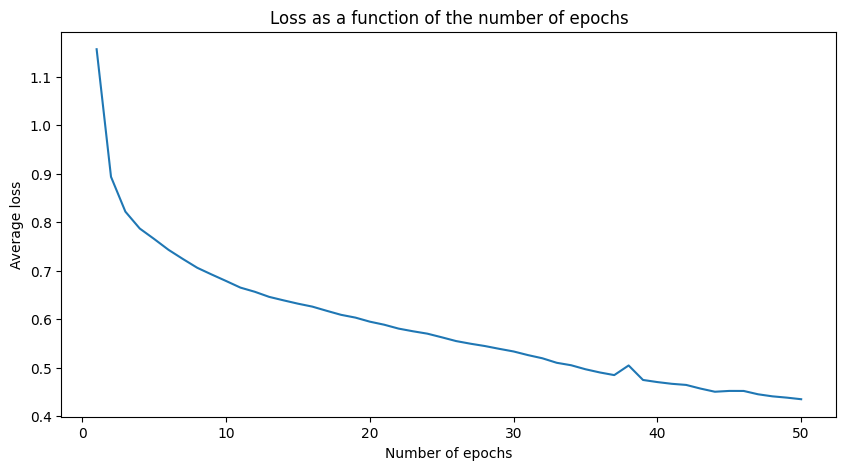

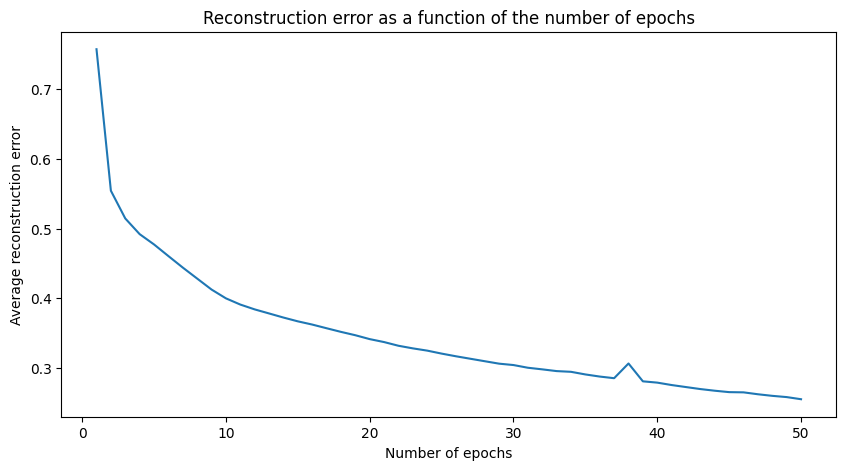

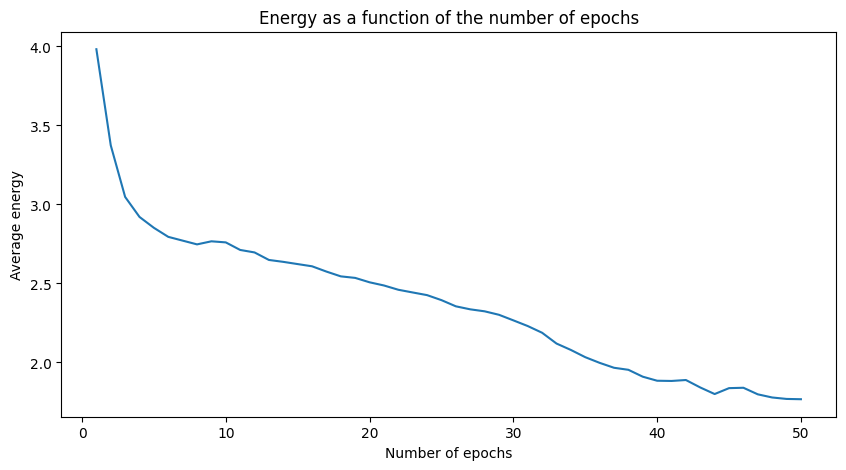

In [17]:
model_GMM.train_model(train_loader_SMOTE)
model_GMM.plot_loss()
model_GMM.plot_reconstruction_error()
model_GMM.plot_energy()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


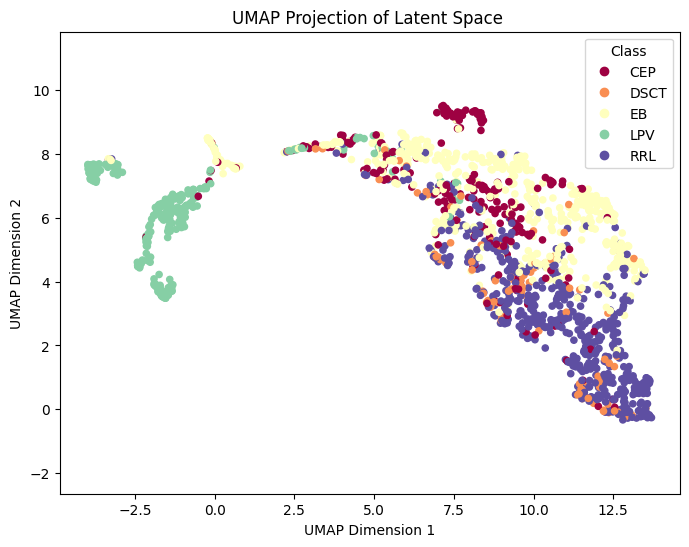

In [18]:
z=model_GMM.get_latent_space(test_loader_SMOTE)
# Prepare data for UMAP
z_feats = z[0].cpu().numpy()
z_labels = z[1].cpu().numpy()
umap_model = umap.UMAP(n_components=2, random_state=42)
z_feats = umap_model.fit_transform(z_feats)

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_feats[:, 0], z_feats[:, 1], c=z_labels, cmap='Spectral', s=20)
plt.gca().set_aspect('equal', 'datalim')
plt.title("UMAP Projection of Latent Space ")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

handles, _ = scatter.legend_elements()
labels = [label_encoder.classes_[label] for label in [0,1,2,3,4]]
plt.legend(handles, labels, title="Class")

plt.show()

In [19]:
db_score = davies_bouldin_score(z_feats, z_labels)
print(f"Davies-Bouldin Score: {db_score}")

sil_score = silhouette_score(z_feats, z_labels)
print(f"Silhouette Score: {sil_score}")

Davies-Bouldin Score: 4.876068341901389
Silhouette Score: 0.0675220787525177


# MultiClass SVDD

## Balance using SMOTE

In [20]:
# Split the DataFrame into features (X) and labels (y)
X = df_top_feats[df_top_feats.columns[:-1]].values
y = df_top_feats['alerceclass'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and test sets (with stratification)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Split the balanced set into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Balance the classes using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Convert the data from numpy to tensors
X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create the PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create the dataloaders
train_loader_SMOTE = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_SMOTE = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader_SMOTE = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Confirm the balanced classes
print("Class distribution in the balanced training set:")
print(Counter(y_train_balanced))
print("Class distribution in validation:")
print(Counter(y_val))
print("Class distribution in test:")
print(Counter(y_test))


Class distribution in the balanced training set:
Counter({2: 1721, 4: 1721, 0: 1721, 3: 1721, 1: 1721})
Class distribution in validation:
Counter({2: 430, 4: 424, 3: 220, 0: 188, 1: 85})
Class distribution in test:
Counter({2: 538, 4: 531, 3: 275, 0: 234, 1: 106})


## Balance using WeightedRandomSampler

In [21]:
# Dividir el DataFrame en características (X) y etiquetas (y)
X = df_top_feats[df_top_feats.columns[:-1]].values
y = df_top_feats['alerceclass'].values
oids = df_top_feats.index  # OID es el índice de df_top_feats

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir en conjunto de entrenamiento y prueba (con estratificación)
X_train_val, X_test, y_train_val, y_test, oids_train_val, oids_test = train_test_split(
    X_scaled, y_encoded, oids, test_size=0.2, random_state=42, stratify=y_encoded
)

# Dividir el conjunto de entrenamiento/validación en entrenamiento y validación
X_train, X_val, y_train, y_val, oids_train, oids_val = train_test_split(
    X_train_val, y_train_val, oids_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Calcular la frecuencia de las clases en el conjunto de entrenamiento
class_counts = Counter(y_train)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# Crear un vector de pesos para cada muestra del conjunto de entrenamiento
sample_weights = np.array([class_weights[label] for label in y_train])

# Convertir los datos de numpy a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Crear los datasets de PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Crear un sampler con los pesos calculados
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Calculate class frequencies and weights for the validation set
val_class_counts = Counter(y_val)
val_class_weights = {cls: 1.0 / count for cls, count in val_class_counts.items()}

# Create a vector of weights for each sample in the validation set
val_sample_weights = np.array([val_class_weights[label] for label in y_val])

# Create a WeightedRandomSampler for the validation set
val_sampler = WeightedRandomSampler(
    weights=val_sample_weights, num_samples=len(val_sample_weights), replacement=True
)

# Crear los dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Confirmar las distribuciones
print("Distribución de clases en el conjunto de entrenamiento original:")
print(class_counts)
print("Distribución de clases en validación:")
print(Counter(y_val))
print("Distribución de clases en test:")
print(Counter(y_test))


Distribución de clases en el conjunto de entrenamiento original:
Counter({2: 1721, 4: 1697, 3: 879, 0: 750, 1: 341})
Distribución de clases en validación:
Counter({2: 430, 4: 424, 3: 220, 0: 188, 1: 85})
Distribución de clases en test:
Counter({2: 538, 4: 531, 3: 275, 0: 234, 1: 106})


## Autoencoder with MCDSVDD architecture

In [22]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class AutoencoderMCDSVDD(nn.Module):
    """Pytorch implementation of an Autoencoder with Multiclass Deep SVDD (MCDSVDD)."""

    def __init__(self, in_dim, z_dim, num_classes):
        super(AutoencoderMCDSVDD, self).__init__()

        self.num_classes = num_classes

        # Encoder Architecture
        self.enc1 = nn.Linear(in_dim, 512)
        self.encbn1 = nn.BatchNorm1d(512)
        self.enc2 = nn.Linear(512, 256)
        self.encbn2 = nn.BatchNorm1d(256)
        self.enc3 = nn.Linear(256, 128)
        self.encbn3 = nn.BatchNorm1d(128)
        self.enc4 = nn.Linear(128, 64)
        self.encbn4 = nn.BatchNorm1d(64)
        self.enc5 = nn.Linear(64, z_dim, bias=False)

        # Decoder Architecture
        self.dec1 = nn.Linear(z_dim, 64)
        self.decbn1 = nn.BatchNorm1d(64)
        self.dec2 = nn.Linear(64, 128)
        self.decbn2 = nn.BatchNorm1d(128)
        self.dec3 = nn.Linear(128, 256)
        self.decbn3 = nn.BatchNorm1d(256)
        self.dec4 = nn.Linear(256, 512)
        self.decbn4 = nn.BatchNorm1d(512)
        self.dec5 = nn.Linear(512, in_dim, bias=False)

    def encode(self, x):
        h = F.leaky_relu(self.encbn1(self.enc1(x)))
        h = F.leaky_relu(self.encbn2(self.enc2(h)))
        h = F.leaky_relu(self.encbn3(self.enc3(h)))
        h = F.leaky_relu(self.encbn4(self.enc4(h)))
        return self.enc5(h)

    def decode(self, x):
        h = F.leaky_relu(self.decbn1(self.dec1(x)))
        h = F.leaky_relu(self.decbn2(self.dec2(h)))
        h = F.leaky_relu(self.decbn3(self.dec3(h)))
        h = F.leaky_relu(self.decbn4(self.dec4(h)))
        return torch.tanh(self.dec5(h))

    def forward(self, x):
        """Forward pass over the network architecture"""
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

    def compute_loss(self, x):
        """Compute MSE Loss for autoencoder training."""
        _, x_hat = self.forward(x)
        return F.mse_loss(x_hat, x, reduction='mean')


    def set_centers(self, dataloader, eps=0.01):
        """Initialize the centers for the hyperspheres."""
        latents, labels = self.get_latent_space(dataloader)
        c = []
        for i in range(self.num_classes):
            ixs = np.where(labels == i)[0]
            c.append(torch.mean(latents[ixs], dim=0))

        # Add small perturbations to avoid zero centers
        c = torch.stack(c)
        for i in range(len(c)):
            c[i][(abs(c[i]) < eps) & (c[i] < 0)] = -eps
            c[i][(abs(c[i]) < eps) & (c[i] > 0)] = eps

        self.c = c

    def get_latent_space(self, dataloader, dataloader_c=None):
        """Extract latent representations from the data and their labels."""
        latents = []
        labels = []

        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.float(), y.long()
                z, _ = self.forward(x)
                latents.append(z.detach().cpu())
                labels.append(y)
        return torch.cat(latents), torch.cat(labels)


    def train_autoencoder(self, train_loader, val_loader, epochs=100, lr=0.001):
        """Train the Autoencoder with MSE loss (reconstruction)."""
        optimizer = optim.Adam(self.parameters(), lr=lr)
        train_loss_list, val_loss_list = [], []

        for epoch in range(epochs):
            self.train()
            total_train_loss = 0
            for batch_idx, (data, target) in enumerate(train_loader): # Unpack data and target
                optimizer.zero_grad()
                loss = self.compute_loss(data) # Pass data (features) to compute_loss
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            total_train_loss /= len(train_loader)
            train_loss_list.append(total_train_loss)

            self.eval()
            total_val_loss = 0
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(val_loader):
                    loss = self.compute_loss(data)
                    total_val_loss += loss.item()

            total_val_loss /= len(val_loader)
            val_loss_list.append(total_val_loss)
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}')


        return train_loss_list, val_loss_list

    def train_mcdsvdd(self, train_loader, val_loader, epochs=100, lr=0.001, lambda_reg=0.5e-6):
        """Train the model using MCDSVDD loss, adjusting centers of hyperspheres, with validation."""
        optimizer = optim.Adam(self.parameters(), lr=lr)
        train_loss_list = []
        val_loss_list = []

        for epoch in range(epochs):
            # Training phase
            self.train()
            total_train_loss = 0
            for data in train_loader:
                optimizer.zero_grad()
                x, labels = data
                x = x.float()
                labels = labels.long()

                # Forward pass to get latent space
                z, _ = self.forward(x)

                # Compute MCDSVDD loss (distance from centers)
                loss = 0
                for i in range(self.num_classes):
                    mask = (labels == i).float()
                    distance = torch.norm(z - self.c[i], p=2, dim=1)
                    loss += mask * distance

                # Add regularization term for weight decay
                l2_reg = sum(torch.norm(param, p=2) for param in self.parameters())
                loss = loss.mean() + lambda_reg * l2_reg

                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            total_train_loss /= len(train_loader)
            train_loss_list.append(total_train_loss)

            # Validation phase
            self.eval()
            total_val_loss = 0
            with torch.no_grad():
                for data in val_loader:
                    x, labels = data
                    x = x.float()
                    labels = labels.long()

                    # Forward pass to get latent space
                    z, _ = self.forward(x)

                    # Compute MCDSVDD loss for validation
                    val_loss = 0
                    for i in range(self.num_classes):
                        mask = (labels == i).float()
                        distance = torch.norm(z - self.c[i], p=2, dim=1)
                        val_loss += mask * distance

                    l2_reg = sum(torch.norm(param, p=2) for param in self.parameters())
                    val_loss = val_loss.mean() + lambda_reg * l2_reg
                    total_val_loss += val_loss.item()

            total_val_loss /= len(val_loader)
            val_loss_list.append(total_val_loss)

            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}')

        return train_loss_list, val_loss_list




## Training with SMOTE




Epoch [1/50], Train Loss: 0.6004, Val Loss: 0.4994
Epoch [2/50], Train Loss: 0.5311, Val Loss: 0.4671
Epoch [3/50], Train Loss: 0.5043, Val Loss: 0.4534
Epoch [4/50], Train Loss: 0.4928, Val Loss: 0.4501
Epoch [5/50], Train Loss: 0.4859, Val Loss: 0.4392
Epoch [6/50], Train Loss: 0.4814, Val Loss: 0.4366
Epoch [7/50], Train Loss: 0.4782, Val Loss: 0.4351
Epoch [8/50], Train Loss: 0.4765, Val Loss: 0.4348
Epoch [9/50], Train Loss: 0.4744, Val Loss: 0.4327
Epoch [10/50], Train Loss: 0.4695, Val Loss: 0.4323
Epoch [11/50], Train Loss: 0.4681, Val Loss: 0.4296
Epoch [12/50], Train Loss: 0.4677, Val Loss: 0.4305
Epoch [13/50], Train Loss: 0.4644, Val Loss: 0.4274
Epoch [14/50], Train Loss: 0.4632, Val Loss: 0.4262
Epoch [15/50], Train Loss: 0.4622, Val Loss: 0.4251
Epoch [16/50], Train Loss: 0.4638, Val Loss: 0.4250
Epoch [17/50], Train Loss: 0.4601, Val Loss: 0.4226
Epoch [18/50], Train Loss: 0.4591, Val Loss: 0.4227
Epoch [19/50], Train Loss: 0.4593, Val Loss: 0.4212
Epoch [20/50], Train 

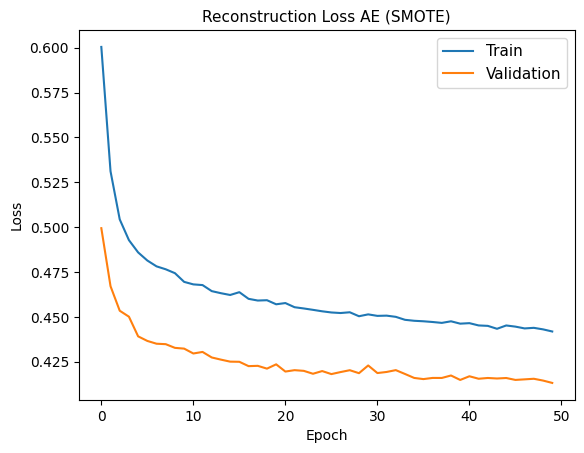

In [23]:
model_SMOTE = AutoencoderMCDSVDD(in_dim=50, z_dim=10, num_classes=5)
train_loss, val_loss = model_SMOTE.train_autoencoder(train_loader_SMOTE, val_loader_SMOTE, epochs=50, lr=0.001)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Reconstruction Loss AE (SMOTE)', fontsize=11)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], fontsize=11)
plt.show()

Epoch [1/50], Train Loss: 0.7552, Val Loss: 0.4498
Epoch [2/50], Train Loss: 0.4589, Val Loss: 0.3836
Epoch [3/50], Train Loss: 0.3969, Val Loss: 0.3362
Epoch [4/50], Train Loss: 0.3589, Val Loss: 0.3367
Epoch [5/50], Train Loss: 0.3261, Val Loss: 0.3136
Epoch [6/50], Train Loss: 0.3121, Val Loss: 0.3026
Epoch [7/50], Train Loss: 0.2960, Val Loss: 0.2894
Epoch [8/50], Train Loss: 0.2815, Val Loss: 0.3118
Epoch [9/50], Train Loss: 0.2716, Val Loss: 0.3151
Epoch [10/50], Train Loss: 0.2461, Val Loss: 0.3239
Epoch [11/50], Train Loss: 0.2586, Val Loss: 0.3000
Epoch [12/50], Train Loss: 0.2445, Val Loss: 0.3092
Epoch [13/50], Train Loss: 0.2325, Val Loss: 0.3009
Epoch [14/50], Train Loss: 0.2167, Val Loss: 0.3191
Epoch [15/50], Train Loss: 0.2130, Val Loss: 0.2748
Epoch [16/50], Train Loss: 0.2086, Val Loss: 0.2882
Epoch [17/50], Train Loss: 0.1983, Val Loss: 0.2992
Epoch [18/50], Train Loss: 0.1991, Val Loss: 0.2928
Epoch [19/50], Train Loss: 0.1907, Val Loss: 0.2990
Epoch [20/50], Train 

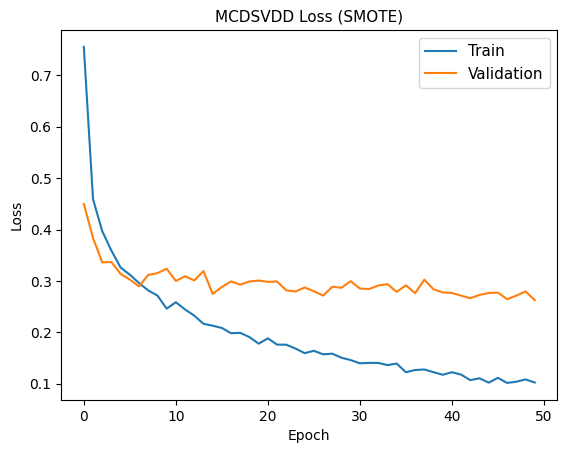

In [24]:
model_SMOTE.set_centers(train_loader_SMOTE)
train_loss, val_loss = model_SMOTE.train_mcdsvdd(train_loader_SMOTE, val_loader_SMOTE, epochs=50, lr=0.001)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('MCDSVDD Loss (SMOTE)', fontsize=11)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], fontsize=11)
plt.show()

## Entrenamiento sin SMOTE

In [25]:
model = AutoencoderMCDSVDD(in_dim=50, z_dim=10, num_classes=5)

Epoch [1/50], Train Loss: 0.6673, Val Loss: 0.5690
Epoch [2/50], Train Loss: 0.5478, Val Loss: 0.5053
Epoch [3/50], Train Loss: 0.5470, Val Loss: 0.4870
Epoch [4/50], Train Loss: 0.5427, Val Loss: 0.4593
Epoch [5/50], Train Loss: 0.5662, Val Loss: 0.5010
Epoch [6/50], Train Loss: 0.5030, Val Loss: 0.4427
Epoch [7/50], Train Loss: 0.6276, Val Loss: 0.4824
Epoch [8/50], Train Loss: 0.5133, Val Loss: 0.5230
Epoch [9/50], Train Loss: 0.6386, Val Loss: 0.4806
Epoch [10/50], Train Loss: 0.5686, Val Loss: 0.4995
Epoch [11/50], Train Loss: 0.5392, Val Loss: 0.4697
Epoch [12/50], Train Loss: 0.5757, Val Loss: 0.5348
Epoch [13/50], Train Loss: 0.5371, Val Loss: 0.4703
Epoch [14/50], Train Loss: 0.4606, Val Loss: 0.4686
Epoch [15/50], Train Loss: 0.6282, Val Loss: 0.4484
Epoch [16/50], Train Loss: 0.5073, Val Loss: 0.4523
Epoch [17/50], Train Loss: 0.4931, Val Loss: 0.4081
Epoch [18/50], Train Loss: 0.5462, Val Loss: 0.4690
Epoch [19/50], Train Loss: 0.5255, Val Loss: 0.5242
Epoch [20/50], Train 

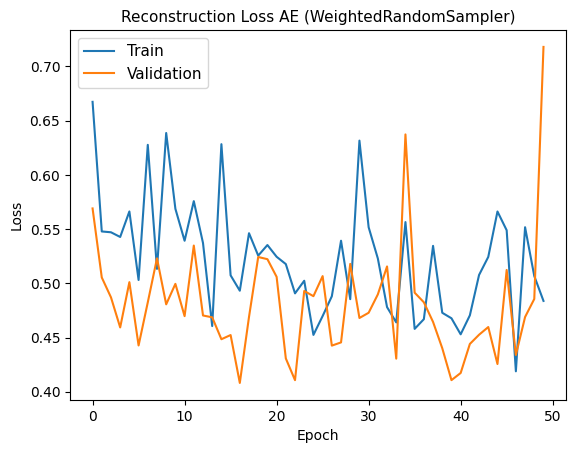

Epoch [1/50], Train Loss: 0.6577, Val Loss: 0.3998
Epoch [2/50], Train Loss: 0.4149, Val Loss: 0.3336
Epoch [3/50], Train Loss: 0.3478, Val Loss: 0.3156
Epoch [4/50], Train Loss: 0.3205, Val Loss: 0.2813
Epoch [5/50], Train Loss: 0.3033, Val Loss: 0.2952
Epoch [6/50], Train Loss: 0.2811, Val Loss: 0.2809
Epoch [7/50], Train Loss: 0.2779, Val Loss: 0.2676
Epoch [8/50], Train Loss: 0.2523, Val Loss: 0.2952
Epoch [9/50], Train Loss: 0.2487, Val Loss: 0.2737
Epoch [10/50], Train Loss: 0.2369, Val Loss: 0.2622
Epoch [11/50], Train Loss: 0.2346, Val Loss: 0.2833
Epoch [12/50], Train Loss: 0.2225, Val Loss: 0.2651
Epoch [13/50], Train Loss: 0.2094, Val Loss: 0.2587
Epoch [14/50], Train Loss: 0.2030, Val Loss: 0.2860
Epoch [15/50], Train Loss: 0.1956, Val Loss: 0.2591
Epoch [16/50], Train Loss: 0.1878, Val Loss: 0.2655
Epoch [17/50], Train Loss: 0.1821, Val Loss: 0.2681
Epoch [18/50], Train Loss: 0.1781, Val Loss: 0.2612
Epoch [19/50], Train Loss: 0.1686, Val Loss: 0.2547
Epoch [20/50], Train 

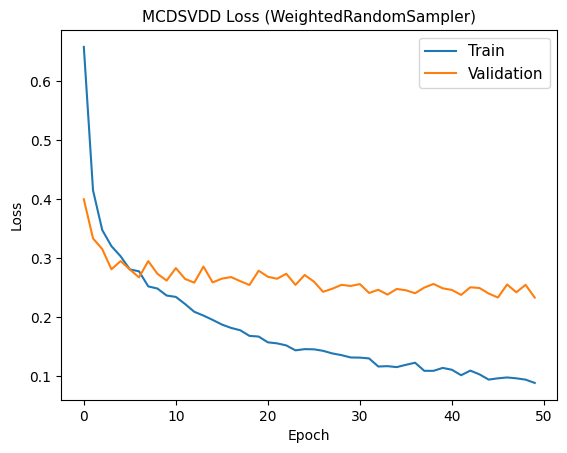

In [26]:
train_loss, val_loss = model.train_autoencoder(train_loader, val_loader, epochs=50, lr=0.001)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Reconstruction Loss AE (WeightedRandomSampler)', fontsize=11)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], fontsize=11)
plt.show()
model.set_centers(train_loader)
train_loss_mcdsvdd, val_loss_mcdsvdd = model.train_mcdsvdd(train_loader_SMOTE, val_loader_SMOTE, epochs=50, lr=0.001)
plt.plot(train_loss_mcdsvdd)
plt.plot(val_loss_mcdsvdd)
plt.title('MCDSVDD Loss (WeightedRandomSampler)', fontsize=11)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], fontsize=11)
plt.show()

## Varias corridas

In [ ]:


def train_and_evaluate(model_class, train_loader, val_loader, test_loader, num_repeats=5, epochs=50, lr=0.001):
    silhouette_scores = []
    davies_bouldin_scores = []

    for i in range(num_repeats):
        print(f"Run {i + 1}/{num_repeats}")

        # Initialize a new model
        model = model_class(in_dim=50, z_dim=10, num_classes=5)

        # Train Autoencoder
        print("Training Autoencoder...")
        model.train_autoencoder(train_loader, val_loader, epochs=epochs, lr=lr)

        # Set centers for MCDSVDD
        model.set_centers(train_loader)

        # Train MCDSVDD
        print("Training MCDSVDD...")
        model.train_mcdsvdd(train_loader, val_loader, epochs=epochs, lr=lr)

        # Evaluate the latent space
        print("Evaluating...")
        model.set_centers(test_loader)
        z = model.get_latent_space(test_loader)
        z_feats = z[0].cpu().numpy()
        z_labels = z[1].cpu().numpy()

        # Compute metrics
        silhouette = silhouette_score(z_feats, z_labels)
        davies_bouldin = davies_bouldin_score(z_feats, z_labels)

        print(f"Run {i + 1} - Silhouette Score: {silhouette:.4f}, Davies-Bouldin Score: {davies_bouldin:.4f}")

        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)

    # Compute mean and standard deviation
    silhouette_mean = np.mean(silhouette_scores)
    silhouette_std = np.std(silhouette_scores)
    davies_bouldin_mean = np.mean(davies_bouldin_scores)
    davies_bouldin_std = np.std(davies_bouldin_scores)

    print("\nFinal Results:")
    print(f"Silhouette Score: {silhouette_mean:.4f} ± {silhouette_std:.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin_mean:.4f} ± {davies_bouldin_std:.4f}")

    return {
        "silhouette_scores": silhouette_scores,
        "davies_bouldin_scores": davies_bouldin_scores,
        "silhouette_mean": silhouette_mean,
        "silhouette_std": silhouette_std,
        "davies_bouldin_mean": davies_bouldin_mean,
        "davies_bouldin_std": davies_bouldin_std
    }

results = train_and_evaluate(
    model_class=AutoencoderMCDSVDD,
    train_loader=train_loader_SMOTE,
    val_loader=val_loader_SMOTE,
    test_loader=test_loader_SMOTE,
    num_repeats=5,
    epochs=50,
    lr=0.001
)


Run 1/5
Training Autoencoder...
Epoch [1/50], Train Loss: 0.5970, Val Loss: 0.5288
Epoch [2/50], Train Loss: 0.5196, Val Loss: 0.4885
Epoch [3/50], Train Loss: 0.4954, Val Loss: 0.4760
Epoch [4/50], Train Loss: 0.4820, Val Loss: 0.4654
Epoch [5/50], Train Loss: 0.4737, Val Loss: 0.4638
Epoch [6/50], Train Loss: 0.4720, Val Loss: 0.4612
Epoch [7/50], Train Loss: 0.4661, Val Loss: 0.4588
Epoch [8/50], Train Loss: 0.4627, Val Loss: 0.4538
Epoch [9/50], Train Loss: 0.4598, Val Loss: 0.4510
Epoch [10/50], Train Loss: 0.4570, Val Loss: 0.4524
Epoch [11/50], Train Loss: 0.4568, Val Loss: 0.4496
Epoch [12/50], Train Loss: 0.4522, Val Loss: 0.4472
Epoch [13/50], Train Loss: 0.4504, Val Loss: 0.4446
Epoch [14/50], Train Loss: 0.4482, Val Loss: 0.4459
Epoch [15/50], Train Loss: 0.4483, Val Loss: 0.4439
Epoch [16/50], Train Loss: 0.4455, Val Loss: 0.4428
Epoch [17/50], Train Loss: 0.4452, Val Loss: 0.4453
Epoch [18/50], Train Loss: 0.4459, Val Loss: 0.4418
Epoch [19/50], Train Loss: 0.4426, Val Lo

In [ ]:
results = train_and_evaluate(
    model_class=AutoencoderMCDSVDD,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_repeats=5,
    epochs=50,
    lr=0.001
)

Run 1/5
Training Autoencoder...
Epoch [1/50], Train Loss: 0.6887, Val Loss: 0.5311
Epoch [2/50], Train Loss: 0.5982, Val Loss: 0.4625
Epoch [3/50], Train Loss: 0.5405, Val Loss: 0.4566
Epoch [4/50], Train Loss: 0.5376, Val Loss: 0.5153
Epoch [5/50], Train Loss: 0.5807, Val Loss: 0.5833
Epoch [6/50], Train Loss: 0.5807, Val Loss: 0.5184
Epoch [7/50], Train Loss: 0.5430, Val Loss: 0.4497
Epoch [8/50], Train Loss: 0.5709, Val Loss: 0.5161
Epoch [9/50], Train Loss: 0.5370, Val Loss: 0.4571
Epoch [10/50], Train Loss: 0.5996, Val Loss: 0.4261
Epoch [11/50], Train Loss: 0.5930, Val Loss: 0.4307
Epoch [12/50], Train Loss: 0.5407, Val Loss: 0.4645
Epoch [13/50], Train Loss: 0.5155, Val Loss: 0.5070
Epoch [14/50], Train Loss: 0.5881, Val Loss: 0.4864
Epoch [15/50], Train Loss: 0.4994, Val Loss: 0.4926
Epoch [16/50], Train Loss: 0.4861, Val Loss: 0.4260
Epoch [17/50], Train Loss: 0.6037, Val Loss: 0.5121
Epoch [18/50], Train Loss: 0.5415, Val Loss: 0.4566
Epoch [19/50], Train Loss: 0.4610, Val Lo

## Detección de anomalías

In [27]:

def plot_umap_projection(data_loader, title, model):
    # Ensure the model is in evaluation mode
    model.eval()

    # Lists to store anomaly scores and labels
    anomaly_scores = []
    labels = []

    # Iterate through the data loader to get anomaly scores
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.float(), y.long()
            z, _ = model.forward(x)

            # Calculate anomaly scores (distance to the centers)
            scores = torch.norm(z - model.c[y], p=2, dim=1)  # Use the center corresponding to each class
            anomaly_scores.append(scores)
            labels.append(y)

    # Concatenate results into a single tensor
    anomaly_scores = torch.cat(anomaly_scores)
    labels = torch.cat(labels)

    # Calculate the mean radius for each class
    num_classes = len(torch.unique(labels))  # Assuming classes are numbered from 0 to n-1
    radios = {}

    for i in range(num_classes):
        # Filter the scores for class i
        class_scores = anomaly_scores[labels == i]

        # Calculate the mean radius for class i
        mean_radius = class_scores.mean().item() + class_scores.std().item()
        radios[i] = mean_radius

    # Classify examples as anomalies if their anomaly score > mean radius of their class
    predictions = []

    for i in range(len(anomaly_scores)):
        # Get the class of the current example
        class_id = labels[i].item()

        # Compare the anomaly score with the mean radius of the class
        if anomaly_scores[i].item() > radios[class_id]:
            predictions.append(1)  # 1 indicates anomaly
        else:
            predictions.append(0)  # 0 indicates normality

    # Convert predictions to a tensor
    predictions = torch.tensor(predictions)

    # Count anomalies
    num_anomalies = (predictions == 1).sum().item()
    num_normals = (predictions == 0).sum().item()

    # Contabilizar anomalias por clase
    class_counts = {}
    for i in range(num_classes):
      class_counts[i] = torch.sum(predictions[labels == i]).item()

    class_names = ['CEP', 'DSCT', 'EB', 'LPV', 'RRL']
    class_counts_named = {class_names[i]: count for i, count in class_counts.items()}

    print(f"Anomalies in {title}: {num_anomalies} / {len(predictions)}")
    print(f"Normal examples in {title}: {num_normals} / {len(predictions)}")
    print(f"Anomalies per class in {title}: {class_counts_named}")

    model.set_centers(data_loader)
    z=model.get_latent_space(data_loader)

    # Prepare data for UMAP
    z_feats = z[0].cpu().numpy()
    z_labels = z[1].cpu().numpy()
    umap_reducer = umap.UMAP(n_components=2)
    embedding = umap_reducer.fit_transform(z_feats)

    silhouette = silhouette_score(z_feats, z_labels)
    davies_bouldin = davies_bouldin_score(z_feats, z_labels)
    print(f'Silhouette Score: {silhouette}')
    print(f'Davies-Bouldin Score: {davies_bouldin}')

    # Filter anomalies from the embedding
    anomalous_indices = np.where(predictions == 1)[0]
    embedding_anomalous = embedding[anomalous_indices]
    z_labels_anomalous = z_labels[anomalous_indices]

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=z_labels, cmap='Spectral', s=20)
    scatter_anomalous = plt.scatter(embedding_anomalous[:, 0], embedding_anomalous[:, 1], c=z_labels_anomalous, cmap='Spectral', marker='x', s=30)

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f"UMAP Projection of Latent Space - {title}")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")

    # Create a legend with the class names
    handles, _ = scatter.legend_elements()
    labels = [label_encoder.classes_[label] for label in [0, 1, 2, 3, 4]]  # Convert labels to class names
    normal_legend = plt.legend(handles, labels, title="Class")

    # Legend for anomalies
    handles_anomalous, _ = scatter_anomalous.legend_elements()
    labels_anomalous = [label_encoder.classes_[label] for label in [0, 1, 2, 3, 4]]  # Convert labels to class names
    anomalous_legend = plt.legend(handles_anomalous, labels_anomalous, title="Anomalous Class")

    plt.show()

    return predictions, davies_bouldin, silhouette



Anomalies in Train: 433 / 8605
Normal examples in Train: 8172 / 8605
Anomalies per class in Train: {'CEP': 29, 'DSCT': 32, 'EB': 25, 'LPV': 261, 'RRL': 86}
Silhouette Score: 0.9411062002182007
Davies-Bouldin Score: 0.0878848374012981


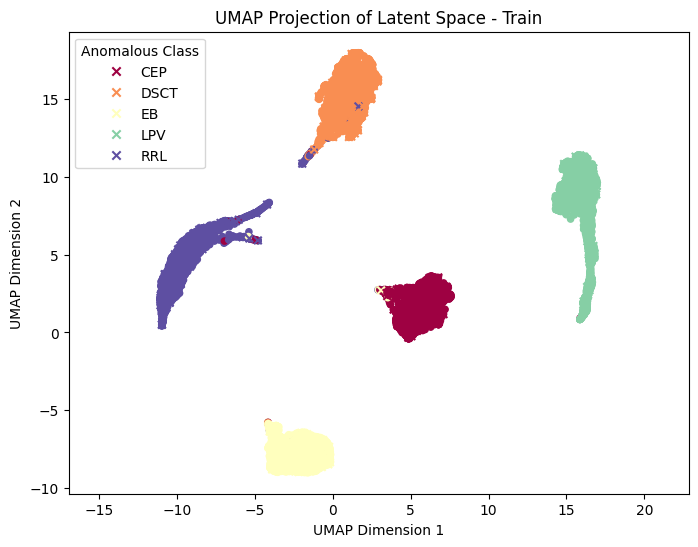

Anomalies in Validation: 159 / 1347
Normal examples in Validation: 1188 / 1347
Anomalies per class in Validation: {'CEP': 39, 'DSCT': 17, 'EB': 32, 'LPV': 15, 'RRL': 56}
Silhouette Score: 0.6318181157112122
Davies-Bouldin Score: 0.9076798021814563


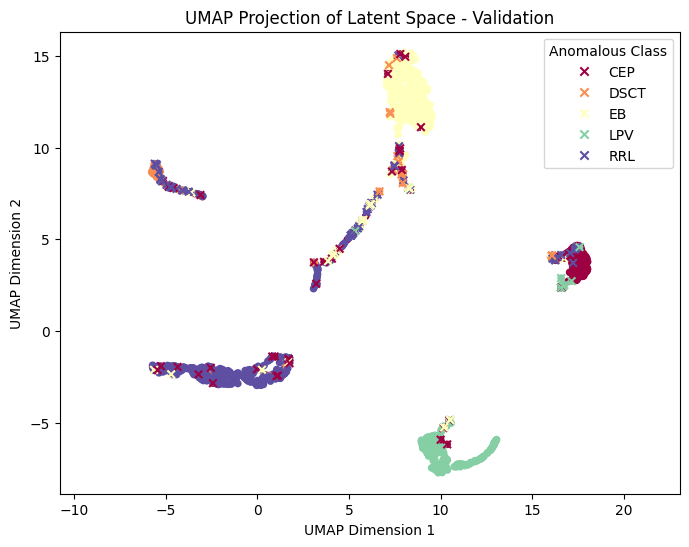

Anomalies in Test: 189 / 1684
Normal examples in Test: 1495 / 1684
Anomalies per class in Test: {'CEP': 41, 'DSCT': 10, 'EB': 49, 'LPV': 24, 'RRL': 65}
Silhouette Score: 0.5844085216522217
Davies-Bouldin Score: 0.9640151163863724


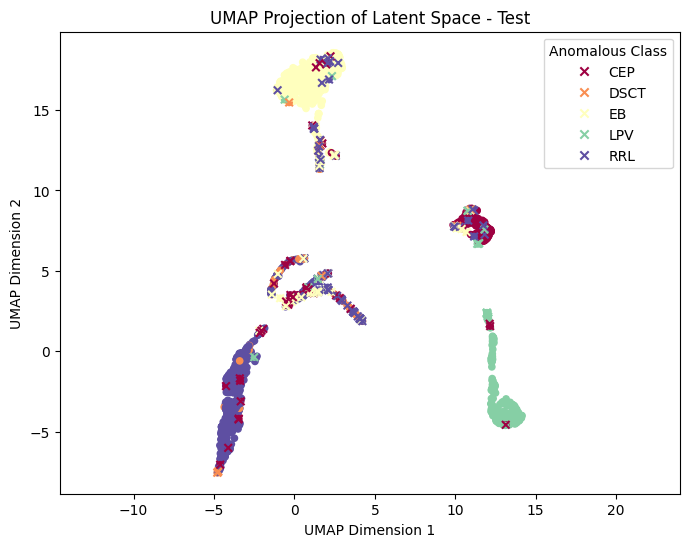

In [28]:
predictions_train_smote, davies_bouldin_train_smote, silhouette_train_smote = plot_umap_projection(train_loader_SMOTE, 'Train', model_SMOTE)
predictions_val_smote, davies_bouldin_val_smote, silhouette_val_smote = plot_umap_projection(val_loader_SMOTE, 'Validation', model_SMOTE)
predictions_test_smote, davies_bouldin_test_smote, silhouette_test_smote = plot_umap_projection(test_loader_SMOTE, 'Test', model_SMOTE)

## Feature analysis

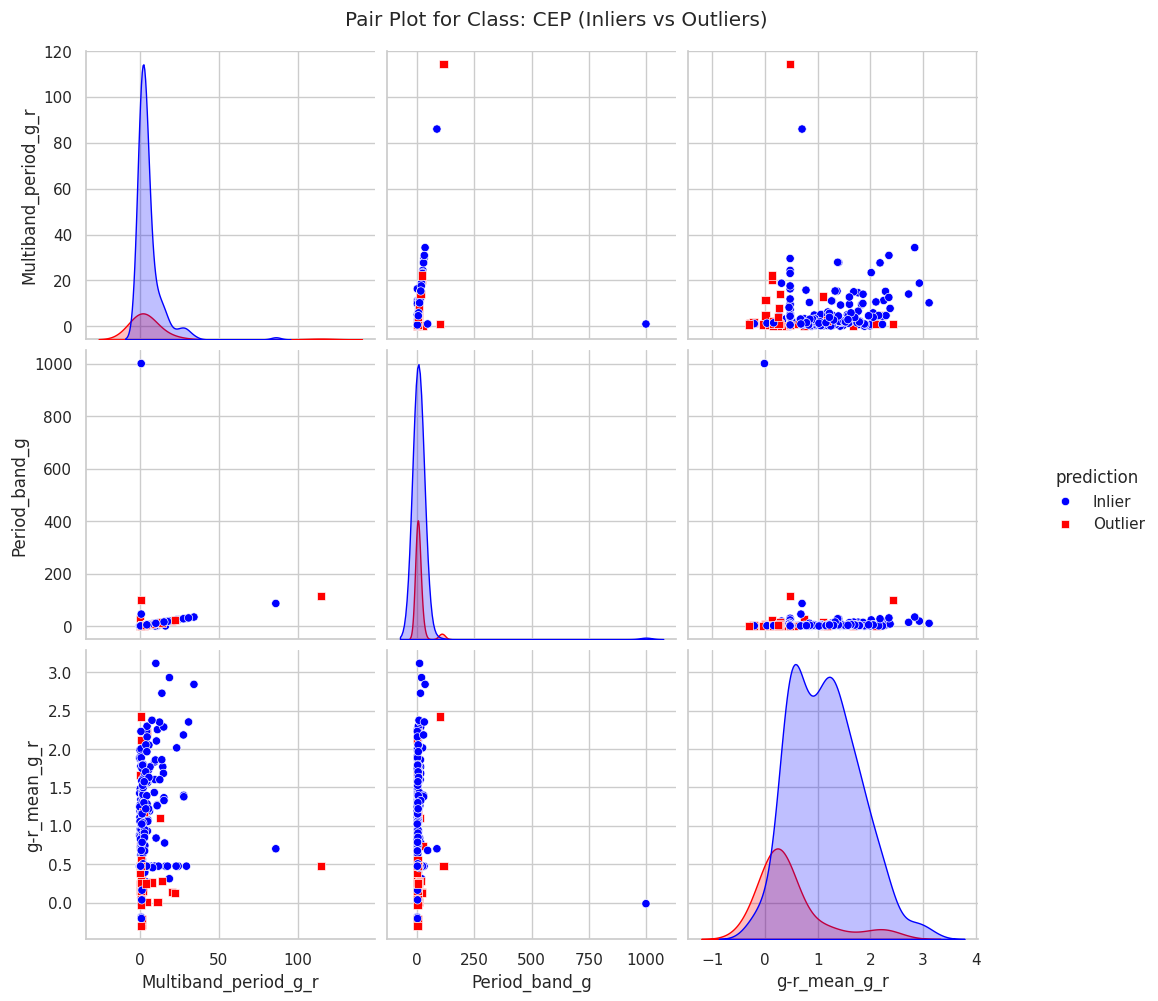

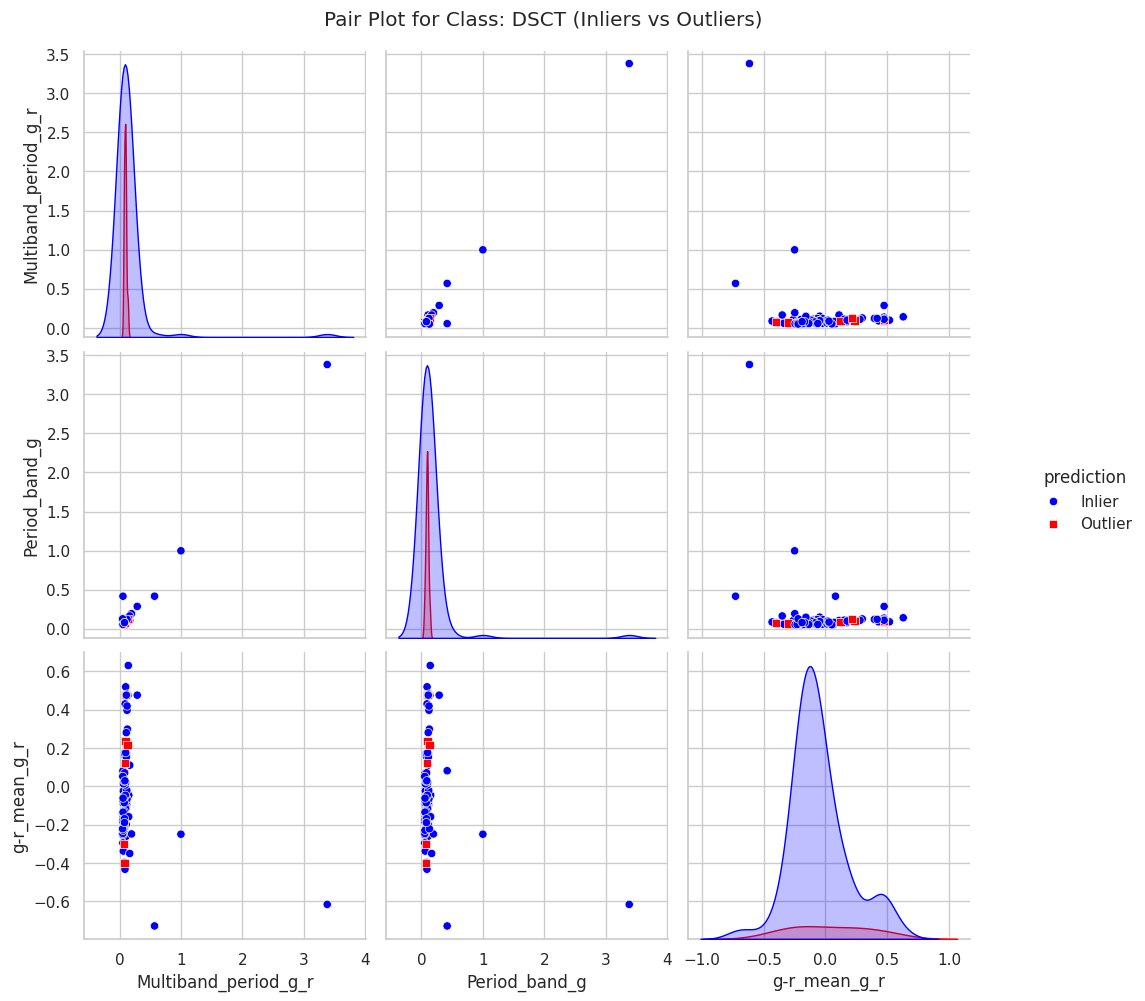

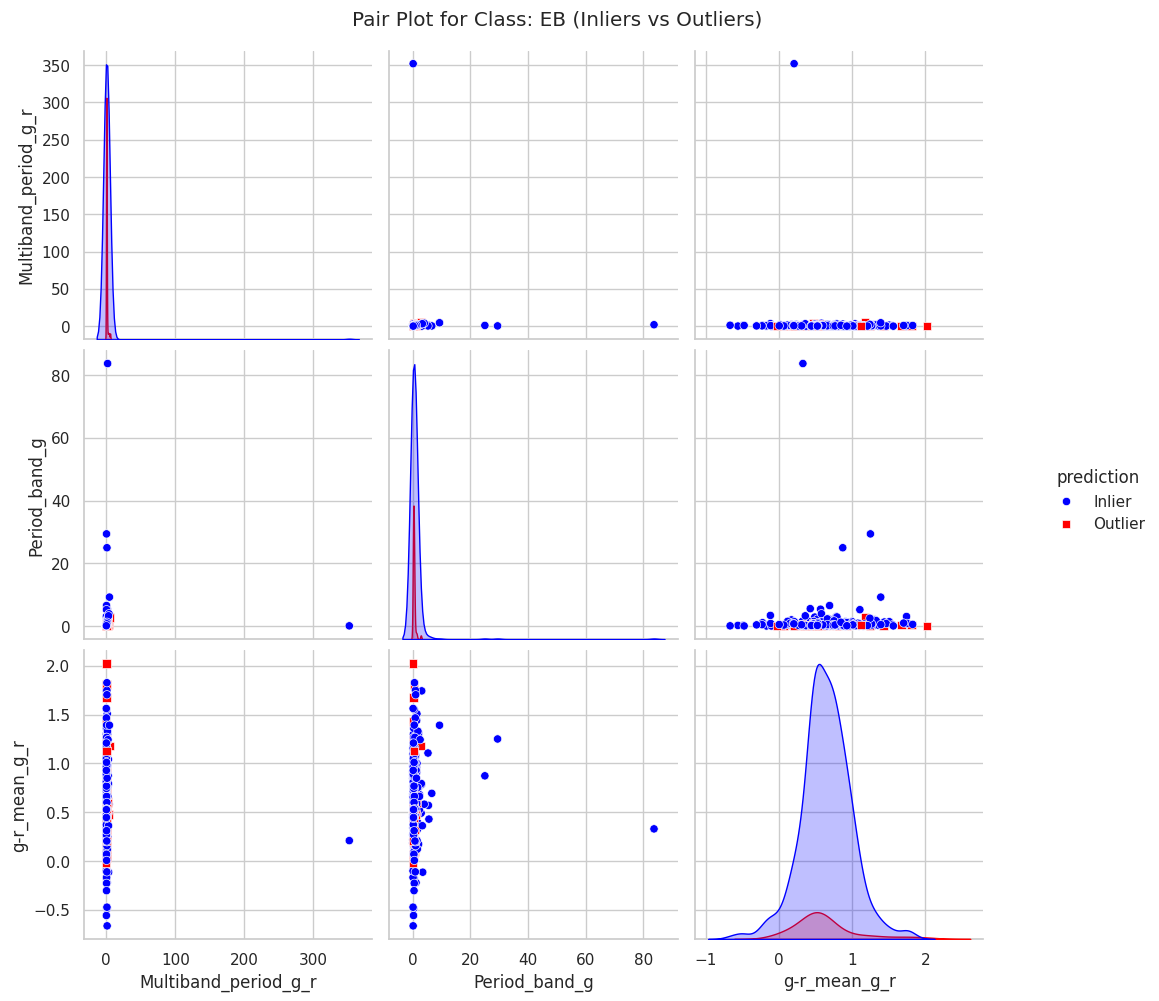

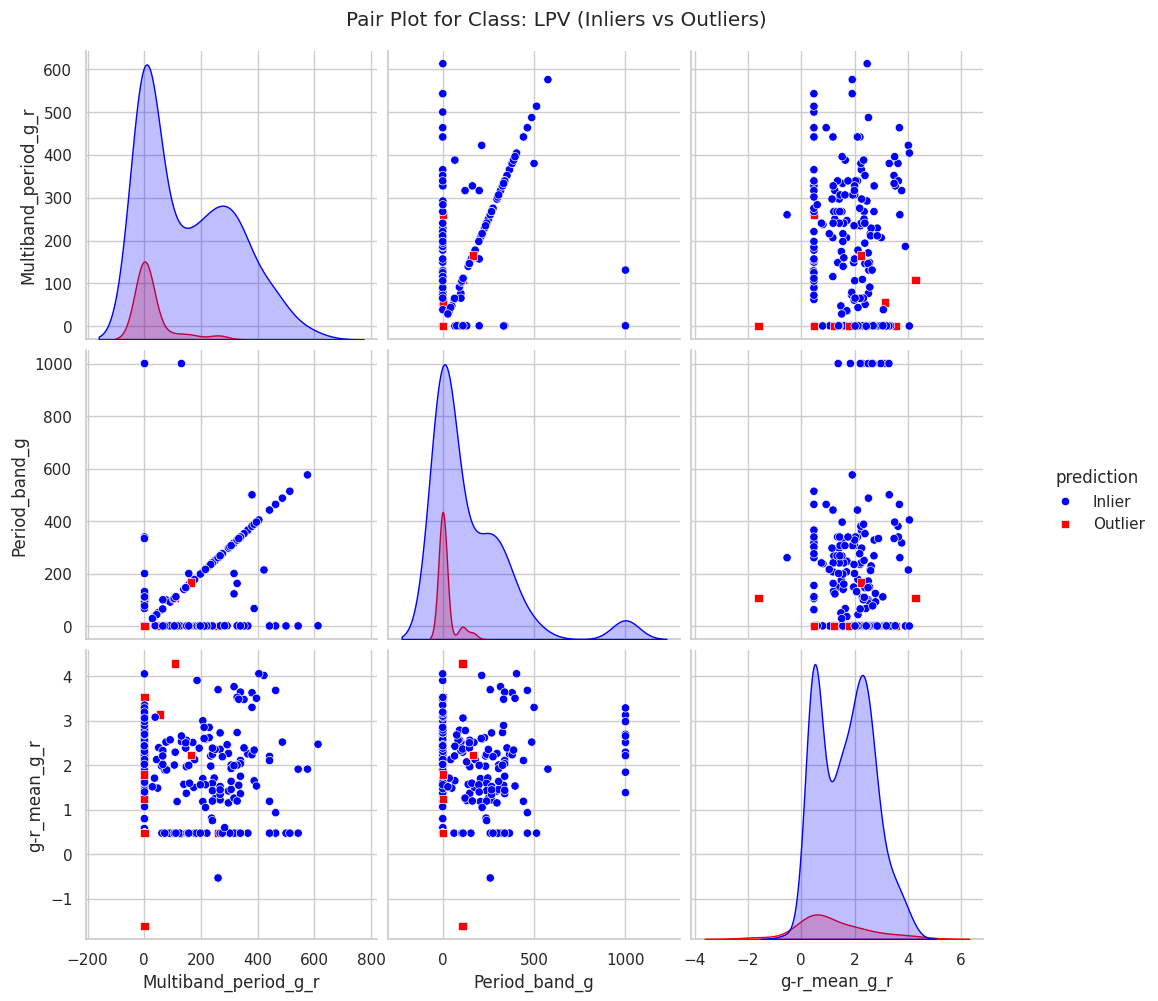

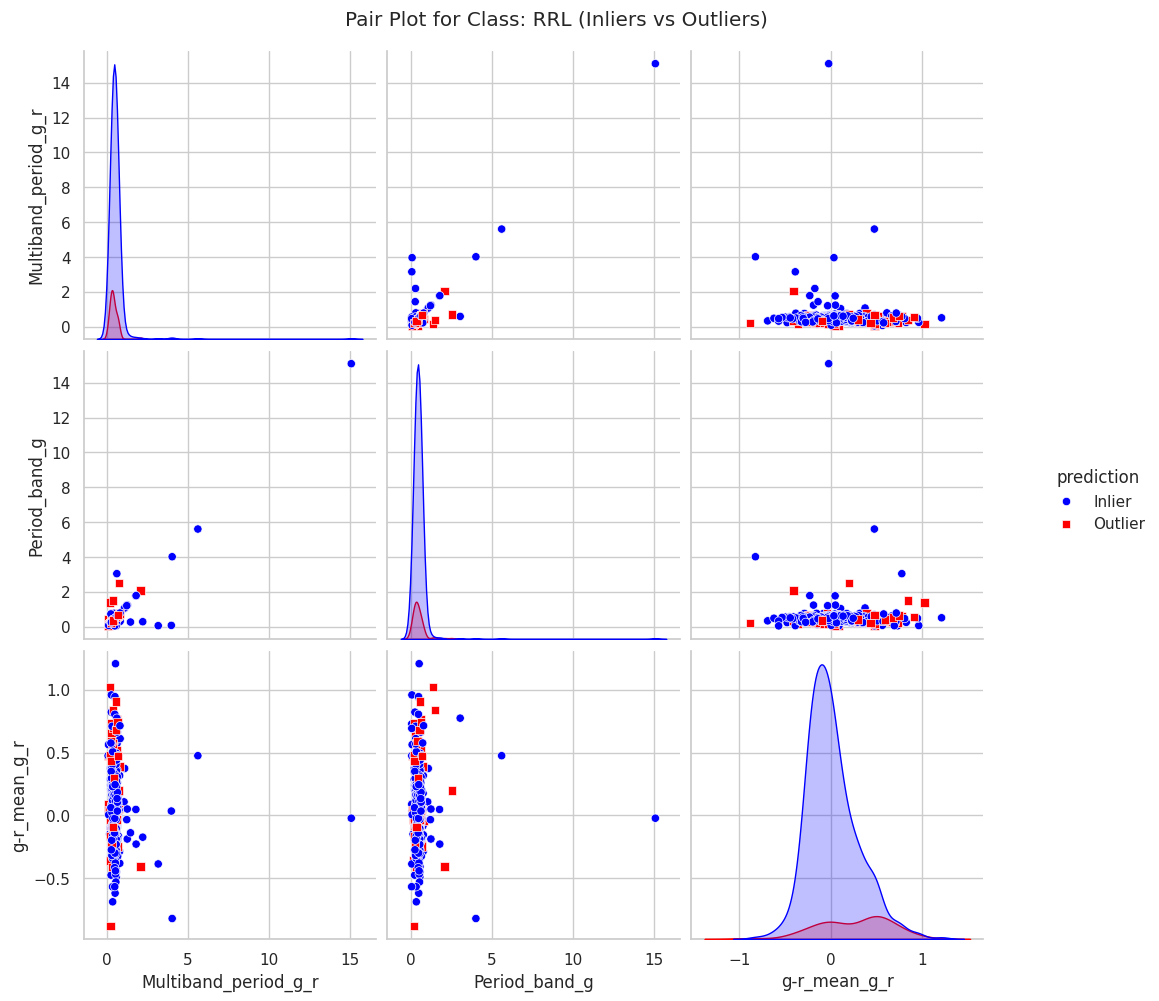

In [29]:
class_names = ['CEP', 'DSCT', 'EB', 'LPV', 'RRL']

# Retrieve test set data using indices
df_test_feats = df_top_feats.loc[oids_test]  # Select rows from the test set using oids_test

# Add predictions to the DataFrame to classify as inliers (0) or outliers (1)
df_test_feats['prediction'] = predictions_test_smote

# Create pair plots for each class
for class_name in class_names:
    # Filter data corresponding to the current class
    class_data = df_test_feats[df_test_feats['alerceclass'] == class_name].copy()

    # Select the first 5 features and the prediction column
    pairplot_data = class_data[df_top_feats.columns[:3].tolist() + ['prediction']].copy()

    # Convert the prediction column to categorical for better visualization
    pairplot_data['prediction'] = pairplot_data['prediction'].map({0: 'Inlier', 1: 'Outlier'})

    # Create the pair plot
    sns.set(style="whitegrid")
    pair_plot = sns.pairplot(
        pairplot_data,
        hue='prediction',
        palette={'Inlier': 'blue', 'Outlier': 'red'},
        diag_kind='kde',
        markers=["o", "s"]
    )

    # Improve visualization
    pair_plot.fig.suptitle(f"Pair Plot for Class: {class_name} (Inliers vs Outliers)", y=1.02)
    pair_plot.fig.set_size_inches(12, 10)

    # Show the plot
    plt.show()


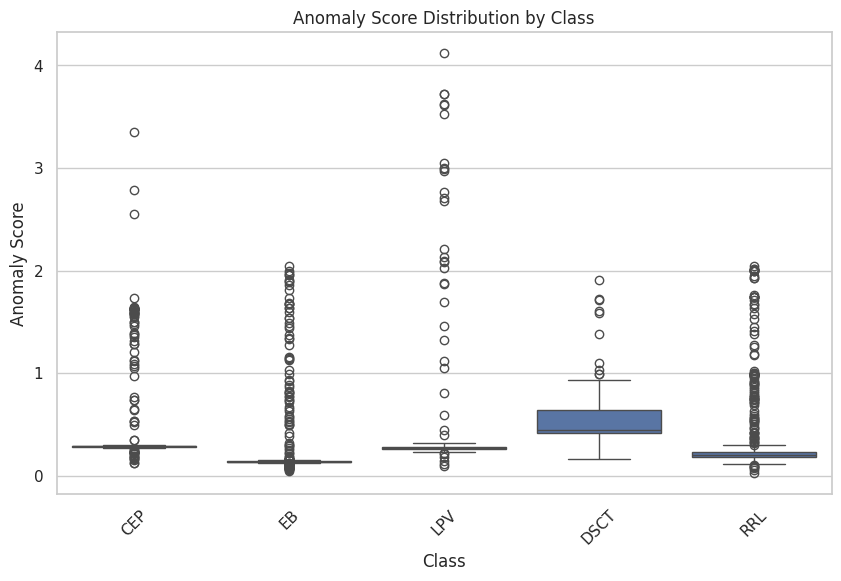

In [30]:
model_SMOTE.eval()
model_SMOTE.set_centers(test_loader_SMOTE)

# Lists to store anomaly scores and labels
anomaly_scores = []
labels = []

# Iterate through the DataLoader to get anomaly scores
with torch.no_grad():
    for x, y in test_loader_SMOTE:
        x, y = x.float(), y.long()
        z, _ = model_SMOTE.forward(x)

        # Calculate anomaly scores (distance to the centers)
        scores = torch.norm(z - model_SMOTE.c[y], p=2, dim=1)  # Use the center corresponding to each class
        anomaly_scores.append(scores)
        labels.append(y)

# Concatenate results into a single tensor
anomaly_scores = torch.cat(anomaly_scores).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

# Create a DataFrame for easier visualization
df_scores = pd.DataFrame({'Anomaly Score': anomaly_scores, 'Class': labels})

# Map class numbers to names
df_scores['Class'] = df_scores['Class'].map({i: class_names[i] for i in range(len(class_names))})

# Plot distributions by class using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Anomaly Score', data=df_scores)
plt.title('Anomaly Score Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Anomaly Score')
plt.xticks(rotation=45)  # Rotate class names if necessary
plt.show()

In [33]:
model_SMOTE.eval()
anomaly_scores = {i: [] for i in range(model_SMOTE.num_classes)}  # Dictionary to store scores by class

with torch.no_grad():
    for x, y in test_loader_SMOTE:
        x, y = x.float(), y.long()
        z, _ = model_SMOTE.forward(x)

        # Calculate the anomaly score for each class and store them in a list
        for class_idx in range(model_SMOTE.num_classes):
            mask = (y == class_idx)  # Select only the examples of the current class
            scores = torch.norm(z[mask] - model_SMOTE.c[class_idx], p=2, dim=1)
            anomaly_scores[class_idx].extend(scores.cpu().numpy())  # Add the scores for this class

anomaly_scores_argmaxs = {class_idx: np.argmax(scores) for class_idx, scores in anomaly_scores.items()}
top_anomaly_oids = {class_idx: oids_test[anomaly_scores_argmaxs[class_idx]] for class_idx in anomaly_scores_argmaxs}
# Class names in the order corresponding to the keys
class_names = ['CEP', 'DSCT', 'EB', 'LPV', 'RRL']

# Create a new dictionary with class names as keys
top_anomaly_oids_named = {class_names[i]: oid for i, oid in top_anomaly_oids.items()}
top_anomaly_oids_named

{'CEP': 'ZTF18aajaecm',
 'DSCT': 'ZTF18aayuzud',
 'EB': 'ZTF18abjuium',
 'LPV': 'ZTF18abbmsxv',
 'RRL': 'ZTF18aajtlyk'}

OID: ZTF18aajaecm - Class: CEP - Period: 0.3036987156372504
OID: ZTF18aayuzud - Class: DSCT - Period: 0.4109885311742681
OID: ZTF18abjuium - Class: EB - Period: 387.75508822962496
OID: ZTF18abbmsxv - Class: LPV - Period: 0.9883992862549404
OID: ZTF18aajtlyk - Class: RRL - Period: 0.5368747946785151


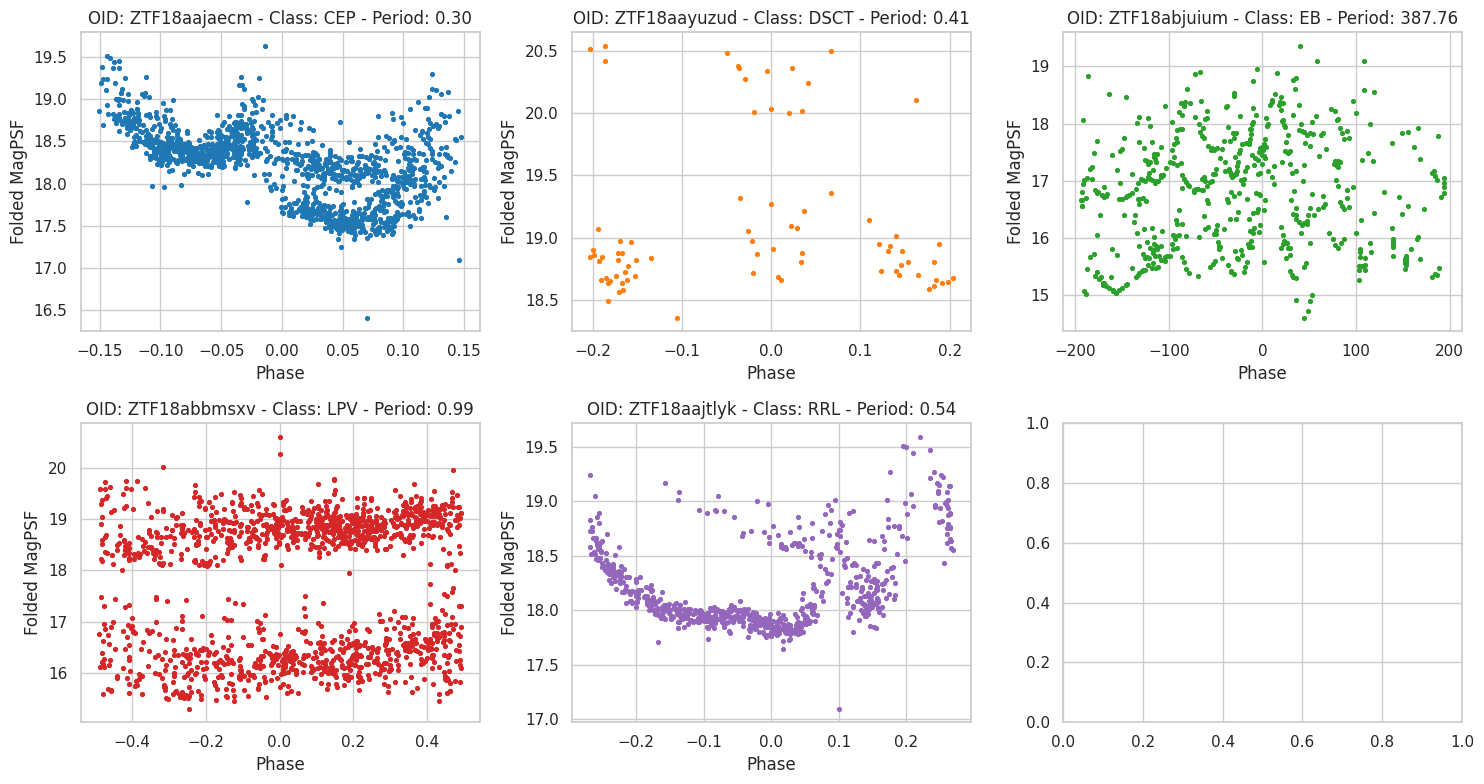

In [34]:
# Color mapping for each class
class_colors = {class_name: plt.cm.tab10(i) for i, class_name in enumerate(class_names)}

# Initialize a rectangular figure with 2 rows and 3 columns to accommodate 5 plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)

# Plot the light curve for each class with the highest anomaly score OID
for i, (class_name, oid) in enumerate(top_anomaly_oids_named.items()):
    # Get multiband period for the current OID
    multiband_period_g_r = df_concatenated.loc[oid, 'Multiband_period_g_r']
    print(f"OID: {oid} - Class: {class_name} - Period: {multiband_period_g_r}")

    # Filter data for the current OID
    subset = lcs[lcs['oid'] == oid]

    # Create a LightCurve using MJD and MagPSF values, including sigma
    time = subset['mjd'].values
    flux = subset['magpsf'].values
    flux_err = subset['sigmapsf'].values
    lc = lk.LightCurve(time=time, flux=flux)

    # Fold the light curve using the specific period for each OID
    lc_folded = lc.fold(period=multiband_period_g_r)

    # Define the subplot position, using 2 rows and 3 columns
    row = i // 3  # Calculate row index
    col = i % 3  # Calculate column index
    ax = axes[row, col]  # Access the correct subplot

    # Plot the folded light curve with flux_err
    lc_folded.scatter(ax=ax, color=class_colors[class_name], s=30 )
    #Set title with period with 2 decimals
    ax.set_title(f'OID: {oid} - Class: {class_name} - Period: {multiband_period_g_r:.2f}')
    ax.set_xlabel('Phase')
    ax.set_ylabel('Folded MagPSF')




# Adjust layout and show plot
plt.tight_layout()
plt.show()